<div style="text-align: center;">
   

# 📊 **Custom Centroid Quantitative Trading Model** 📊
### *A K-Means Approach to Financial Markets*

**📅 Date:** 2025-03-23  
**✍️ Author:** *Varshini Vishnubhotla*   

---

📝 **Objective:**  
This notebook explores an **Unsupervised approach** to trading using financial indicators, machine learning, and quantitative strategies.

## 🔑 **Key Topics**  
<ul class="bullet-list">
    <li>📈 Feature Engineering: Technical Indicators, Returns Analysis, Fama-French Factors</li>
    <li>🎯 Clustering & Machine Learning for Increasing Returns and Reducing Volatility in Trading</li>
    <li>📊 Risk & Performance Metrics</li>
</ul>

---

💡 *"Ultimate Lesson Learned: In Trading, Consistency is Key."* 🚀
</div>


In [1]:
import sys

In [2]:
print(sys.prefix)

D:\anaconda3\envs\trading_strategy


In [3]:
import platform
print(platform.python_version())

3.10.16


In [4]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import ssl
import certifi
import urllib.request

In [5]:
warnings.filterwarnings('ignore')

# Unsupervised Learning Trading Strategy
#### This notebook implements an unsupervised learning approach to stock selection and portfolio optimization. It clusters stocks based on technical indicators and fundamental factors, then constructs an optimized portfolio from the selected cluster.

In [6]:
# create an SSL context w/ certifi's CA Bundle
sslContext = ssl.create_default_context(cafile=certifi.where())

In [7]:
# read HTML content w/ urllib with the created SSL context
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = urllib.request.urlopen(url, context=sslContext)
html = response.read()

In [8]:
# parse the HTML content with pandas
sp500 = pd.read_html(html)
sp500 = sp500[0]

In [9]:
# Format the ticker symbols
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbolsList = sp500['Symbol'].unique().tolist()

In [10]:
# Define the date range
endDate = '2024-07-08'
startDate = pd.to_datetime(endDate) - pd.DateOffset(365*8)

In [11]:
# Download the stock data
df = yf.download(tickers=symbolsList, start=startDate, end=endDate).stack()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['ETR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2016-07-10 00:00:00 -> 2024-07-08)')
['SW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2016-07-10 00:00:00 -> 2024-07-08) (Yahoo error = "Data doesn\'t exist for startDate = 1468123200, endDate = 1720411200")')


In [12]:
df.index.names=['date','ticker']

In [13]:
df.columns = df.columns.str.lower()
df

Price              adj close       close        high         low        open  \
date       ticker                                                              
2016-07-11 A             NaN   42.489376   42.835654   42.442579   42.685912   
           AAPL          NaN   22.194117   22.347447   22.136903   22.141480   
           ABBV          NaN   44.411911   44.853614   44.218667   44.342896   
           ABT           NaN   35.804573   35.966087   35.702567   35.728067   
           ACGL          NaN   22.425356   22.552144   22.200311   22.501430   
...                      ...         ...         ...         ...         ...   
2024-07-05 XYL           NaN  133.117432  133.157100  130.004154  131.421992   
           YUM           NaN  127.258018  127.819806  126.380853  127.455146   
           ZBH           NaN  107.528442  107.677775  105.696642  106.343746   
           ZBRA          NaN  310.510010  312.429993  308.700012  312.250000   
           ZTS           NaN  173.607361  174.599630  172.902843  173.845496   

Price                  volume  
date       ticker              
2016-07-11 A        1094700.0  
           AAPL    95179600.0  
           ABBV     9641500.0  
           ABT      9052300.0  
           ACGL     1187700.0  
...                       ...  
2024-07-05 XYL      1106300.0  
           YUM      1477600.0  
           ZBH      1045000.0  
           ZBRA      245700.0  
           ZTS      1812100.0  

[986305 rows x 6 columns]

In [14]:
df.isna().sum()

Price
adj close    986305
close             0
high              0
low               0
open              0
volume            0
dtype: int64

In [15]:
df = df.drop('adj close', axis=1, inplace=False)
df

Price                   close        high         low        open      volume
date       ticker                                                            
2016-07-11 A        42.489376   42.835654   42.442579   42.685912   1094700.0
           AAPL     22.194117   22.347447   22.136903   22.141480  95179600.0
           ABBV     44.411911   44.853614   44.218667   44.342896   9641500.0
           ABT      35.804573   35.966087   35.702567   35.728067   9052300.0
           ACGL     22.425356   22.552144   22.200311   22.501430   1187700.0
...                       ...         ...         ...         ...         ...
2024-07-05 XYL     133.117432  133.157100  130.004154  131.421992   1106300.0
           YUM     127.258018  127.819806  126.380853  127.455146   1477600.0
           ZBH     107.528442  107.677775  105.696642  106.343746   1045000.0
           ZBRA    310.510010  312.429993  308.700012  312.250000    245700.0
           ZTS     173.607361  174.599630  172.902843  173.845496   1812100.0

[986305 rows x 5 columns]

# Calculate Features and technical indicators for each stock
###### *`Garman-Klass Volatility: Measures intraday volatility using high, low, and close prices. Helps identify high-volatility periods, useful for risk management and market conditions.`
###### *`RSI: Identifies overbought (above 70) and oversold (below 30) conditions. Signals potential price reversals based on momentum.`
###### *`Bollinger Bands: Shows price volatility by expanding and contracting around a moving average. Prices near upper band suggest overbought, near lower band suggest oversold.`
###### *`ATR: Measures market volatility by calculating the average range of price movements. Helps assess market risk and adjust position sizes based on volatility.`
###### *`MACD: Shows trend direction with the difference between two moving averages. A cross above the signal line suggests an upward trend, while a cross below indicates a downward trend.`
###### *`Dollar Volume: Represents total traded value (price * volume) of a stock. High dollar volume signals increased liquidity and potential price movement.`

In [16]:
df['garmanKlassVol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close'])-np.log(df['open']))**2)

In [17]:
df['RSI'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

In [18]:
df['bbLow'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

In [19]:
df['bbMid'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bbHigh'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def computeATR(stockData):
    atr = pandas_ta.atr(high=stockData['high'],
                        low=stockData['low'],
                        close=stockData['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['ATR'] = df.groupby(level=1, group_keys=False).apply(computeATR)

def computeMACD(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['MACD'] = df.groupby(level=1, group_keys=False)['close'].apply(computeMACD)

df['dollarVolume'] = (df['close']*df['volume'])/1e6

df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2016-07-11 A        42.489376   42.835654   42.442579   42.685912   1094700.0   
           AAPL     22.194117   22.347447   22.136903   22.141480  95179600.0   
           ABBV     44.411911   44.853614   44.218667   44.342896   9641500.0   
           ABT      35.804573   35.966087   35.702567   35.728067   9052300.0   
           ACGL     22.425356   22.552144   22.200311   22.501430   1187700.0   
...                       ...         ...         ...         ...         ...   
2024-07-05 XYL     133.117432  133.157100  130.004154  131.421992   1106300.0   
           YUM     127.258018  127.819806  126.380853  127.455146   1477600.0   
           ZBH     107.528442  107.677775  105.696642  106.343746   1045000.0   
           ZBRA    310.510010  312.429993  308.700012  312.250000    245700.0   
           ZTS     173.607361  174.599630  172.902843  173.845496   1812100.0   

Price              garmanKlassVol        RSI     bbLow     bbMid    bbHigh  \
date       ticker                                                            
2016-07-11 A             0.000034        NaN       NaN       NaN       NaN   
           AAPL          0.000043        NaN       NaN       NaN       NaN   
           ABBV          0.000101        NaN       NaN       NaN       NaN   
           ABT           0.000025        NaN       NaN       NaN       NaN   
           ACGL          0.000119        NaN       NaN       NaN       NaN   
...                           ...        ...       ...       ...       ...   
2024-07-05 XYL           0.000224  45.011483  4.880790  4.919815  4.958839   
           YUM           0.000063  34.055508  4.843773  4.894338  4.944902   
           ZBH           0.000125  38.410719  4.649044  4.688394  4.727745   
           ZBRA          0.000060  53.177470  5.693120  5.722956  5.752792   
           ZTS           0.000047  54.566063  5.116198  5.153209  5.190219   

Price                   ATR      MACD  dollarVolume  
date       ticker                                    
2016-07-11 A            NaN       NaN     46.513120  
           AAPL         NaN       NaN   2112.427140  
           ABBV         NaN       NaN    428.197440  
           ABT          NaN       NaN    324.113737  
           ACGL         NaN       NaN     26.634595  
...                     ...       ...           ...  
2024-07-05 XYL     0.948769 -1.072214    147.267815  
           YUM     0.291120 -1.728278    188.036448  
           ZBH    -0.749139 -0.890284    112.367222  
           ZBRA   -0.299779 -0.070548     76.292309  
           ZTS     0.756223  0.236771    314.593899  

[986305 rows x 13 columns]

# Aggregate to Monthly lvl + Filter Top 150 Liquid Stocks for Each Month
###### In order to reduce training time and experiment with features and strategies, we will convert business daily data into month-end frequency.  In doing this we reduce noise frequency in our data.
###### *`Liquid stocks likely have high daily trading volume. So, they are actively bought and sold by investors, making their pools of buyers and sellers larger, leading to easier trade executions without causing major price fluctuations.`

In [20]:
lastCols = [c for c in df.columns.unique(0) if c not in ['dollarVolume', 'volume', 'open',
                                                          'high', 'low']]

data = (pd.concat([df.unstack('ticker')['dollarVolume'].resample('M').mean().stack('ticker').to_frame('dollarVolume'),
                   df.unstack()[lastCols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollarVolume       ATR      MACD        RSI    bbHigh  \
date       ticker                                                          
2016-08-31 A          87.361265 -1.372548 -0.132273  49.171259  3.839005   
           AAPL     2709.867877 -1.318514 -0.116318  56.336403  3.272417   
           ABBV      301.132967 -1.531567 -0.278335  39.550147  3.882072   
           ABT       371.618504 -1.243672 -0.311408  34.489702  3.700515   
           ACGL       28.987310 -1.186929  0.622807  79.816700  3.305771   
...                         ...       ...       ...        ...       ...   
2024-07-31 GEHC      158.557460 -0.940493 -0.595581  43.994461  4.391974   
           KVUE      237.783784 -0.938086 -0.200413  43.853652  2.967061   
           VLTO      135.281591 -0.649774 -1.806821  44.493228  4.642446   
           GEV       347.386929 -0.384885 -1.371641  55.811072  5.224199   
           SOLV       71.421093 -1.481290 -0.897731  31.035559  4.071095   

                      bbLow     bbMid       close  garmanKlassVol  
date       ticker                                                  
2016-08-31 A       3.795732  3.817369   43.968082        0.000029  
           AAPL    3.232082  3.252249   24.412783        0.000032  
           ABBV    3.818057  3.850064   44.627735        0.000109  
           ABT     3.615160  3.657838   35.939598        0.000151  
           ACGL    3.184625  3.245198   25.655241        0.000053  
...                     ...       ...         ...             ...  
2024-07-31 GEHC    4.327987  4.359980   76.974434        0.000040  
           KVUE    2.910169  2.938615   17.800674        0.000048  
           VLTO    4.555581  4.599013   95.419678        0.000122  
           GEV     5.088970  5.156584  176.097610        0.000342  
           SOLV    3.914520  3.992807   49.900002        0.000373  

[47108 rows x 9 columns]

##### calculate 5-year rolling avg of dollar volume for each stock before filtering top 150

In [21]:
data['dollarVolume'] = (data.loc[:, 'dollarVolume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollarVolRank'] = (data.groupby('date')['dollarVolume'].rank(ascending=False))

data = data[data['dollarVolRank']<150].drop(['dollarVolume', 'dollarVolRank'], axis=1)

data

ATR      MACD        RSI    bbHigh     bbLow  \
date       ticker                                                      
2017-07-31 AAPL   -1.156167 -0.181704  50.672293  3.613582  3.530035   
           ABBV   -1.315251 -0.110873  45.182804  4.005393  3.942505   
           ABT    -1.339389  0.295647  55.959067  3.828870  3.744178   
           ACN    -1.245254  0.092274  60.835396  4.768681  4.703483   
           ADBE   -1.315643  0.022361  55.447822  5.033305  4.944062   
...                     ...       ...        ...       ...       ...   
2024-07-31 UBER    0.543618  0.548753  53.943789  4.300515  4.241062   
           CRWD    1.208867  1.625272  61.714480  6.014157  5.874645   
           PLTR   -0.067394  0.934781  66.343296  3.329640  3.157946   
           ABNB   -1.225067  0.220430  53.636013  5.044679  4.982239   
           KVUE   -0.938086 -0.200413  43.853652  2.967061  2.910169   

                      bbMid       close  garmanKlassVol  
date       ticker                                        
2017-07-31 AAPL    3.571809   34.689045        0.000085  
           ABBV    3.973949   50.561256        0.000028  
           ABT     3.786524   43.102165        0.000065  
           ACN     4.736082  114.994751        0.000026  
           ADBE    4.988684  146.490005        0.000080  
...                     ...         ...             ...  
2024-07-31 UBER    4.270789   71.059998        0.000106  
           CRWD    5.944401  389.679993        0.000117  
           PLTR    3.243793   27.230000        0.000323  
           ABNB    5.013459  152.500000        0.000045  
           KVUE    2.938615   17.800674        0.000048  

[12665 rows x 8 columns]

# Calculate monthly returns for different time horizons as features
##### in order to express time series dynamics that reflect- like momentum patterns- we will compute historical returns(over various monthly periods as identified by lags) using the .pct_change(lag) method.


In [22]:
def calculateReturns(df):

    outlierCutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return{lag}m'] = (df['close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlierCutoff),
                                                     upper=x.quantile(1-outlierCutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculateReturns).dropna()

data

ATR      MACD        RSI    bbHigh     bbLow  \
date       ticker                                                      
2018-07-31 AAPL   -1.077305 -0.167517  52.605300  3.857179  3.804900   
           ABBV   -0.225311 -0.727232  45.920942  4.315494  4.208566   
           ABT    -0.964524  0.533089  62.882521  4.099941  4.006169   
           ACN    -0.852824 -0.173283  42.887846  5.050001  4.989138   
           ADBE   -0.658679 -0.027959  45.877512  5.590025  5.486423   
...                     ...       ...        ...       ...       ...   
2024-07-31 MRNA   -0.164149 -0.738131  40.351547  5.090710  4.710021   
           UBER    0.543618  0.548753  53.943789  4.300515  4.241062   
           CRWD    1.208867  1.625272  61.714480  6.014157  5.874645   
           PLTR   -0.067394  0.934781  66.343296  3.329640  3.157946   
           ABNB   -1.225067  0.220430  53.636013  5.044679  4.982239   

                      bbMid       close  garmanKlassVol  return1m  return2m  \
date       ticker                                                             
2018-07-31 AAPL    3.831040   45.072208        0.000108  0.027983  0.009109   
           ABBV    4.262030   69.049774        0.000085  0.005633 -0.029587   
           ABT     4.053055   58.538490        0.000028  0.079433  0.034389   
           ACN     5.019569  144.875122        0.000099 -0.026041  0.011460   
           ADBE    5.538224  244.679993        0.000267  0.003568 -0.009270   
...                     ...         ...             ...       ...       ...   
2024-07-31 MRNA    4.900366  118.320000        0.000339 -0.003621 -0.088943   
           UBER    4.270789   71.059998        0.000106 -0.022290  0.049134   
           CRWD    5.944401  389.679993        0.000117  0.016937  0.114596   
           PLTR    3.243793   27.230000        0.000323  0.075010  0.120712   
           ABNB    5.013459  152.500000        0.000045  0.005738  0.025784   

                   return3m  return6m  return9m  return12m  
date       ticker                                           
2018-07-31 AAPL    0.049478  0.022909  0.014540   0.022060  
           ABBV   -0.011801 -0.028860  0.005495   0.026310  
           ABT     0.042361  0.010427  0.022867   0.025837  
           ACN     0.017611  0.000037  0.013581   0.019435  
           ADBE    0.033577  0.034384  0.037837   0.043676  
...                     ...       ...       ...        ...  
2024-07-31 MRNA    0.023641  0.026645  0.050475   0.000466  
           UBER    0.023535  0.014266  0.056639   0.030657  
           CRWD    0.100291  0.048972  0.091803   0.076074  
           PLTR    0.074169  0.091646  0.070091   0.026736  
           ABNB   -0.012926  0.009441  0.028627   0.000170  

[10496 rows x 14 columns]

# Fam-French Factors Analysis 
#### In this section we will be downlaoding fama-french factor data and calculate factor betas for each stock using rolling regression (RollingOLS)
#### The betas will reveal each stock's sensitivity to each factor.  We will then incorporate the betas as factors in our clustering algorithm later.
#### The main factors we will be working with are:
###### Market Risk Factor: High market factor indicates that a stock moves strongly with the overall market.
###### Size Factor(difference between small and large cap-stocks(SMB)): Positive SMB beta shows stock behaves more like a small-cap stock.  Negative SMB shows large cap-stock behavior.
###### Value Factor(difference between high and low book to market ratio stocks(HML)): Positive HML beta indicates value-stock behavior(low volatility-less price changes in short-run).  Negative beta indicates growth-stock behavior(high volatility - more price changes in short-run).
###### Profitability Factor(difference between firms with robust and weak profitability(RMW)): Positive RMW beta suggests performance that mimicks high profitable companies.  Negative beta indicates weak profitability.
###### Investment Factor(difference between firms that invest convervatively versus aggressively(CMA)): Positive CMA beta indicates behavior of conservatively investing companies.  Negative beta for aggressive investors.

### In this project specifically, the Fama-French factors will help us understand various risk factors for each stock, group similar stocks, balance different types of risk in portfolios, and observe which stocks are expected to outperform others in certain market conditions.

### In our trading strategy we will combine our factor betas with the technical indicators and past returns calculator above in order to write an algorithm that will select stocks from a specific cluster to create a portfolio using frontier optimization.

In [23]:
factorData = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = '2010')[0].drop('RF', axis=1)
factorData.index = factorData.index.to_timestamp()
factorData = factorData.resample('M').last().div(100)
factorData.index.name = 'date'
factorData = factorData.join(data['return1m']).sort_index()
factorData

Mkt-RF     SMB     HML     RMW     CMA  return1m
date       ticker                                                  
2018-07-31 AAPL    0.0319 -0.0193  0.0045  0.0155  0.0035  0.027983
           ABBV    0.0319 -0.0193  0.0045  0.0155  0.0035  0.005633
           ABT     0.0319 -0.0193  0.0045  0.0155  0.0035  0.079433
           ACN     0.0319 -0.0193  0.0045  0.0155  0.0035 -0.026041
           ADBE    0.0319 -0.0193  0.0045  0.0155  0.0035  0.003568
...                   ...     ...     ...     ...     ...       ...
2024-07-31 VZ      0.0124  0.0828  0.0574  0.0022  0.0043  0.000728
           WDAY    0.0124  0.0828  0.0574  0.0022  0.0043  0.024915
           WFC     0.0124  0.0828  0.0574  0.0022  0.0043  0.003873
           WMT     0.0124  0.0828  0.0574  0.0022  0.0043  0.034412
           XOM     0.0124  0.0828  0.0574  0.0022  0.0043 -0.015202

[10496 rows x 6 columns]

We will filter our the stocks with less than 10 months of data

In [24]:
observations  = factorData.groupby(level=1).size()
validStocks = observations[observations >= 10]
factorData = factorData[factorData.index.get_level_values('ticker').isin(validStocks.index)]
factorData

Mkt-RF     SMB     HML     RMW     CMA  return1m
date       ticker                                                  
2018-07-31 AAPL    0.0319 -0.0193  0.0045  0.0155  0.0035  0.027983
           ABBV    0.0319 -0.0193  0.0045  0.0155  0.0035  0.005633
           ABT     0.0319 -0.0193  0.0045  0.0155  0.0035  0.079433
           ACN     0.0319 -0.0193  0.0045  0.0155  0.0035 -0.026041
           ADBE    0.0319 -0.0193  0.0045  0.0155  0.0035  0.003568
...                   ...     ...     ...     ...     ...       ...
2024-07-31 VZ      0.0124  0.0828  0.0574  0.0022  0.0043  0.000728
           WDAY    0.0124  0.0828  0.0574  0.0022  0.0043  0.024915
           WFC     0.0124  0.0828  0.0574  0.0022  0.0043  0.003873
           WMT     0.0124  0.0828  0.0574  0.0022  0.0043  0.034412
           XOM     0.0124  0.0828  0.0574  0.0022  0.0043 -0.015202

[10475 rows x 6 columns]

##### Calculating Rolling Factor Betas

In [25]:
betas = (factorData.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return1m'], 
                                     exog=sm.add_constant(x.drop('return1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-07-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-07-31 VZ      0.688726 -0.841018  0.634314  0.301405 -0.477397
           WDAY    1.085137 -0.577897 -0.396551 -1.676007  0.237085
           WFC     1.107772 -0.109317  1.177490 -0.806360 -0.612759
           WMT     0.461351  0.198065 -0.156061  0.915713  0.070760
           XOM     0.665326 -0.255761  0.277156  0.505216  1.096593

[10475 rows x 5 columns]

joining rolling factors data to the main features data frame

In [26]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = (data.join(betas.groupby('ticker').shift()))
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10303 entries, (Timestamp('2018-07-31 00:00:00'), 'AAPL') to (Timestamp('2024-07-31 00:00:00'), 'CRWD')
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ATR             10303 non-null  float64
 1   MACD            10303 non-null  float64
 2   RSI             10303 non-null  float64
 3   bbHigh          10303 non-null  float64
 4   bbLow           10303 non-null  float64
 5   bbMid           10303 non-null  float64
 6   close           10303 non-null  float64
 7   garmanKlassVol  10303 non-null  float64
 8   return1m        10303 non-null  float64
 9   return2m        10303 non-null  float64
 10  return3m        10303 non-null  float64
 11  return6m        10303 non-null  float64
 12  return9m        10303 non-null  float64
 13  return12m       10303 non-null  float64
 14  Mkt-RF          10303 non-null  float64
 15  SMB             10303 non-null  float64
 16

In [27]:
data = data.drop('close', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10303 entries, (Timestamp('2018-07-31 00:00:00'), 'AAPL') to (Timestamp('2024-07-31 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ATR             10303 non-null  float64
 1   MACD            10303 non-null  float64
 2   RSI             10303 non-null  float64
 3   bbHigh          10303 non-null  float64
 4   bbLow           10303 non-null  float64
 5   bbMid           10303 non-null  float64
 6   garmanKlassVol  10303 non-null  float64
 7   return1m        10303 non-null  float64
 8   return2m        10303 non-null  float64
 9   return3m        10303 non-null  float64
 10  return6m        10303 non-null  float64
 11  return9m        10303 non-null  float64
 12  return12m       10303 non-null  float64
 13  Mkt-RF          10303 non-null  float64
 14  SMB             10303 non-null  float64
 15  HML             10303 non-null  float64
 16

In [30]:
data

ATR      MACD        RSI    bbHigh     bbLow  \
date       ticker                                                      
2018-07-31 AAPL   -1.077305 -0.167517  52.605300  3.857179  3.804900   
           ABBV   -0.225311 -0.727232  45.920942  4.315494  4.208566   
           ABT    -0.964524  0.533089  62.882521  4.099941  4.006169   
           ACN    -0.852824 -0.173283  42.887846  5.050001  4.989138   
           ADBE   -0.658679 -0.027959  45.877512  5.590025  5.486423   
...                     ...       ...        ...       ...       ...   
2024-07-31 WMT     1.508747  1.859305  69.246705  4.246552  4.194077   
           XOM     0.745781 -0.106094  48.755325  4.745308  4.670303   
           MRNA   -0.164149 -0.738131  40.351547  5.090710  4.710021   
           UBER    0.543618  0.548753  53.943789  4.300515  4.241062   
           CRWD    1.208867  1.625272  61.714480  6.014157  5.874645   

                      bbMid  garmanKlassVol  return1m  return2m  return3m  \
date       ticker                                                           
2018-07-31 AAPL    3.831040        0.000108  0.027983  0.009109  0.049478   
           ABBV    4.262030        0.000085  0.005633 -0.029587 -0.011801   
           ABT     4.053055        0.000028  0.079433  0.034389  0.042361   
           ACN     5.019569        0.000099 -0.026041  0.011460  0.017611   
           ADBE    5.538224        0.000267  0.003568 -0.009270  0.033577   
...                     ...             ...       ...       ...       ...   
2024-07-31 WMT     4.220315        0.000154  0.034412  0.032030  0.057975   
           XOM     4.707805        0.000100 -0.015202 -0.016727 -0.011343   
           MRNA    4.900366        0.000339 -0.003621 -0.088943  0.023641   
           UBER    4.270789        0.000106 -0.022290  0.049134  0.023535   
           CRWD    5.944401        0.000117  0.016937  0.114596  0.100291   

                   return6m  return9m  return12m    Mkt-RF       SMB  \
date       ticker                                                      
2018-07-31 AAPL    0.022909  0.014540   0.022060  1.314164 -0.302556   
           ABBV   -0.028860  0.005495   0.026310  0.475536  0.477879   
           ABT     0.010427  0.022867   0.025837  0.789177 -0.120337   
           ACN     0.000037  0.013581   0.019435  1.212416 -0.199866   
           ADBE    0.034384  0.037837   0.043676  1.258815 -0.475090   
...                     ...       ...        ...       ...       ...   
2024-07-31 WMT     0.042039  0.029537   0.024247  0.482219  0.181268   
           XOM     0.019371  0.010620   0.007545  0.742076  0.056708   
           MRNA    0.026645  0.050475   0.000466  1.294664  1.624758   
           UBER    0.014266  0.056639   0.030657  1.470524 -0.134733   
           CRWD    0.048972  0.091803   0.076074  1.014129 -2.620149   

                        HML       RMW       CMA  
date       ticker                                
2018-07-31 AAPL   -0.622596  0.423877  0.573807  
           ABBV   -0.182529  0.498873  0.480824  
           ABT    -0.451114  0.224998  0.955603  
           ACN    -0.251864  0.310511  0.076633  
           ADBE   -0.244476  0.210909 -0.463852  
...                     ...       ...       ...  
2024-07-31 WMT    -0.147878  0.923006  0.020725  
           XOM     0.401946  0.849840  0.533142  
           MRNA   -0.160100  2.127674  0.780858  
           UBER   -0.179416 -2.732423 -0.455312  
           CRWD    1.537015 -3.477240 -2.871659  

[10303 rows x 18 columns]

## Model Portion

#### For each month, we will fit a K-Means clustering algorithm to group similar assets based on their features.

Initializing predefined centroids for each cluster based on our analysis above.

In [43]:
targetRSIvalues = [30, 45, 55,70]
initialCentroids = np.zeros((len(targetRSIvalues), 18))
initialCentroids[:, 6] = targetRSIvalues
initialCentroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [44]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def getClusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initialCentroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(getClusters)

data

ATR      MACD        RSI    bbHigh     bbLow  \
date       ticker                                                      
2018-07-31 AAPL   -1.077305 -0.167517  52.605300  3.857179  3.804900   
           ABBV   -0.225311 -0.727232  45.920942  4.315494  4.208566   
           ABT    -0.964524  0.533089  62.882521  4.099941  4.006169   
           ACN    -0.852824 -0.173283  42.887846  5.050001  4.989138   
           ADBE   -0.658679 -0.027959  45.877512  5.590025  5.486423   
...                     ...       ...        ...       ...       ...   
2024-07-31 WMT     1.508747  1.859305  69.246705  4.246552  4.194077   
           XOM     0.745781 -0.106094  48.755325  4.745308  4.670303   
           MRNA   -0.164149 -0.738131  40.351547  5.090710  4.710021   
           UBER    0.543618  0.548753  53.943789  4.300515  4.241062   
           CRWD    1.208867  1.625272  61.714480  6.014157  5.874645   

                      bbMid  garmanKlassVol  return1m  return2m  return3m  \
date       ticker                                                           
2018-07-31 AAPL    3.831040        0.000108  0.027983  0.009109  0.049478   
           ABBV    4.262030        0.000085  0.005633 -0.029587 -0.011801   
           ABT     4.053055        0.000028  0.079433  0.034389  0.042361   
           ACN     5.019569        0.000099 -0.026041  0.011460  0.017611   
           ADBE    5.538224        0.000267  0.003568 -0.009270  0.033577   
...                     ...             ...       ...       ...       ...   
2024-07-31 WMT     4.220315        0.000154  0.034412  0.032030  0.057975   
           XOM     4.707805        0.000100 -0.015202 -0.016727 -0.011343   
           MRNA    4.900366        0.000339 -0.003621 -0.088943  0.023641   
           UBER    4.270789        0.000106 -0.022290  0.049134  0.023535   
           CRWD    5.944401        0.000117  0.016937  0.114596  0.100291   

                   return6m  return9m  return12m    Mkt-RF       SMB  \
date       ticker                                                      
2018-07-31 AAPL    0.022909  0.014540   0.022060  1.314164 -0.302556   
           ABBV   -0.028860  0.005495   0.026310  0.475536  0.477879   
           ABT     0.010427  0.022867   0.025837  0.789177 -0.120337   
           ACN     0.000037  0.013581   0.019435  1.212416 -0.199866   
           ADBE    0.034384  0.037837   0.043676  1.258815 -0.475090   
...                     ...       ...        ...       ...       ...   
2024-07-31 WMT     0.042039  0.029537   0.024247  0.482219  0.181268   
           XOM     0.019371  0.010620   0.007545  0.742076  0.056708   
           MRNA    0.026645  0.050475   0.000466  1.294664  1.624758   
           UBER    0.014266  0.056639   0.030657  1.470524 -0.134733   
           CRWD    0.048972  0.091803   0.076074  1.014129 -2.620149   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAPL   -0.622596  0.423877  0.573807        3  
           ABBV   -0.182529  0.498873  0.480824        0  
           ABT    -0.451114  0.224998  0.955603        2  
           ACN    -0.251864  0.310511  0.076633        0  
           ADBE   -0.244476  0.210909 -0.463852        0  
...                     ...       ...       ...      ...  
2024-07-31 WMT    -0.147878  0.923006  0.020725        1  
           XOM     0.401946  0.849840  0.533142        3  
           MRNA   -0.160100  2.127674  0.780858        0  
           UBER   -0.179416 -2.732423 -0.455312        3  
           CRWD    1.537015 -3.477240 -2.871659        2  

[10303 rows x 19 columns]

##### And now we will visualize our clusters...

In [45]:
import math    

In [51]:
def plotClusters(data, ax, colors):
    cluster0 = data[data['cluster']==0]
    cluster1 = data[data['cluster']==1]
    cluster2 = data[data['cluster']==2]
    cluster3 = data[data['cluster']==3]
    
    ax.scatter(cluster0.iloc[:,0], cluster0.iloc[:,2], color=colors[0], label='cluster 0')
    ax.scatter(cluster1.iloc[:,0], cluster1.iloc[:,2], color=colors[1], label='cluster 1')
    ax.scatter(cluster2.iloc[:,0], cluster2.iloc[:,2], color=colors[2], label='cluster 2')
    ax.scatter(cluster3.iloc[:,0], cluster3.iloc[:,2], color=colors[3], label='cluster 3')
    
    ax.legend(fontsize=8)
    return ax

#### Let's format the cluster plots in a 3 per row layout to save space and be able to comprehend the plots more concisely

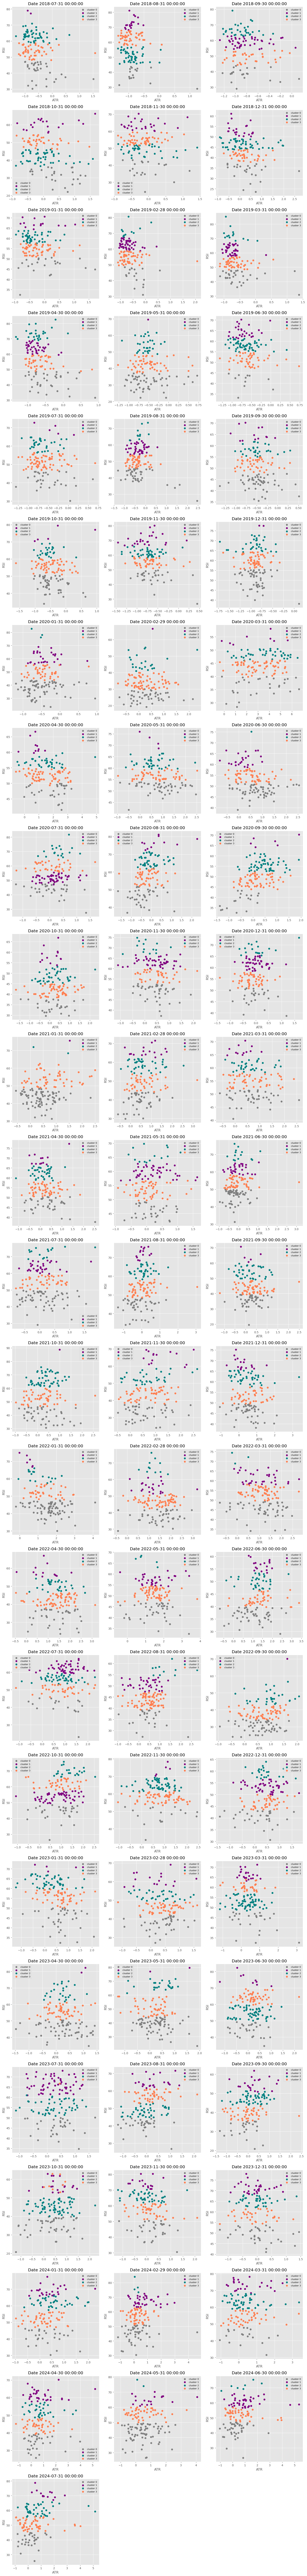

In [52]:
#execute the plotting function with 3 plots per row
plt.style.use('ggplot')
clusterColors = ['gray', 'purple', 'teal', 'coral']

#get unique dates
dates = data.index.get_level_values('date').unique().tolist()
dates.sort()  # Make sure dates are in order

#calculate rows needed
numPlots = len(dates)
plotsPerRow = 3
numRows = math.ceil(numPlots / plotsPerRow)

fig, axes = plt.subplots(numRows, plotsPerRow, figsize=(15, 5*numRows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # space between plots

if numRows > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # handle case if only one row

# loop through dates and create plots
for i, date in enumerate(dates):
    if i < len(axes):  
        # get data for iteration's this date
        dateData = data.xs(date, level=0)
        
        # set title and plot
        axes[i].set_title(f'Date {date}')
        plotClusters(dateData, axes[i], clusterColors)

         # axis labels
        axes[i].set_xlabel('ATR')
        axes[i].set_ylabel('RSI')

        

# hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Portfolio Opimization

#### For each month, select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

#### `First we will filter only stocks corresponding to the cluster we choose based on hypothesis`
#### `Momentum is persistent and ideally, stocks that cluster around an RSI value of 70 should continuously outperform the in the following month. A higher ATR value also indicates larger price swings. So a cluster that clusters around lower ATR values indicates lower risk. So in final analysis of there factors we would look for a cluster that revolves around the RSI value of 70 and lower ATR values. Hence, the cluster I would choose for portfolio optimization based on the graphical analysis above is: Cluster 1 `


#### Cluster 1 most consistently had an RSI congregating around an RSI value of 70.  Cluster 2 followed closely behind.  While cluster 2 points congregated around a particular ATR value and less of a spread, they didn't meet the RSI criteria for momentul quite as well as cluster 1.  Additionally, cluster 1 did have several time periods where the ATR points were clustered around a singular and lower value as well.  So in the final analysis of consistency, we pick Cluster 1.

In [53]:
filteredDf = data[data['cluster']==1].copy()
filteredDf = filteredDf.reset_index(level=1)
filteredDf.index = filteredDf.index+pd.DateOffset(1)
filteredDf = filteredDf.reset_index().set_index(['date','ticker'])
dates = filteredDf.index.get_level_values('date').unique().tolist()
fixedDates = {}
for d in dates:
    fixedDates[d.strftime('%Y-%m-%d')] = filteredDf.xs(d, level = 0).index.tolist()

fixedDates

{'2018-08-01': ['LLY', 'PFE'],
 '2018-09-01': ['AAPL',
  'ADP',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'ISRG',
  'LLY',
  'LOW',
  'MDT',
  'ORLY',
  'QCOM',
  'REGN',
  'TGT',
  'TJX',
  'UAL',
  'V'],
 '2018-10-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMZN',
  'AZO',
  'BA',
  'BDX',
  'BIIB',
  'BKNG',
  'BMY',
  'BRK-B',
  'CAT',
  'CHTR',
  'COST',
  'CRM',
  'CSX',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'ELV',
  'GILD',
  'HD',
  'HUM',
  'IBM',
  'JNJ',
  'KO',
  'LUV',
  'MAR',
  'MCD',
  'MSFT',
  'NFLX',
  'NKE',
  'NOC',
  'NVDA',
  'OXY',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'T',
  'TGT',
  'UAL',
  'UNH',
  'XOM'],
 '2018-11-01': ['AMT',
  'CI',
  'CMCSA',
  'DG',
  'F',
  'GM',
  'JNJ',
  'KO',
  'KR',
  'MCD',
  'MO',
  'MRK',
  'PG',
  'PM',
  'SBUX',
  'TSLA',
  'VZ',
  'WBA',
  'WMT'],
 '2018-12-01': ['ABBV',
  'ABT',
  'AMGN',
  'AMT',
  'AXP',
  'CI',
  'DAL',
  'DHR',
  'GM',
  'JNJ',
  'KO',
  'LLY',
  'MCD',
  'MDLZ',
  'MDT',
  'MRK',
  'NEE',
  'PEP',
  'P

# Defining Portfolio Optimization Function

#### `We will now define a function that optimizes portfolio weights using the PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.`
#### `To optimize the weights of a given portfolio we would need to provide the function prices of the past 1 year.`
#### `Apply single stock weight bounds constraint for diversification(minimum half of equaly weight and maximum 10% of the portfolio).`

In [73]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimizeWeights(prices, lowerBound=-0.05):
    # Check for NaN values that could cause issues
    if prices.isnull().any().any():
        prices = prices.fillna(method='ffill').fillna(method='bfill')
    
    # Check if we have enough data
    if len(prices) < 30:  # At least 30 days of data
        raise ValueError("Not enough price data for reliable optimization")
    
    # Calculate returns with robust approach
    try:
        returns = expected_returns.mean_historical_return(
            prices=prices,
            frequency=252,
            compounding=False  # Use log returns for better stability
        )
        
        # Handle negative expected returns which can cause problems
        # For portfolio optimization, we might use a floor on expected returns
        returns = returns.clip(lower=0.001)  # Set a minimum expected return
        
        # Use robust covariance estimation to handle outliers
        cov = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
        
        # Try optimization with more robust settings
        ef = EfficientFrontier(
            expected_returns=returns,
            cov_matrix=cov,
            weight_bounds=(lowerBound, 0.1),  # Your original bounds
            solver="ECOS",  # Alternative solver that can be more stable
            solver_options={
                "max_iters": 1000,
                "eps": 1e-5
            }
        )
        
        # Optimize with regularization to improve numerical stability
        weights = ef.max_sharpe(risk_free_rate=0.02)  # Set a reasonable risk-free rate
        
        return ef.clean_weights()
        
    except Exception as e:
        # Fall back to minimum variance optimization if max sharpe fails
        try:
            ef = EfficientFrontier(
                expected_returns=returns,
                cov_matrix=cov,
                weight_bounds=(lowerBound, 0.1)
            )
            weights = ef.min_volatility()
            return ef.clean_weights()
        except:
            raise Exception(f"Optimization failed: {str(e)}")
   

In [69]:
stocks = data.index.get_level_values('ticker').unique().tolist()

newDf = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

newDf

[*********************100%***********************]  155 of 155 completed

1 Failed download:
['WDC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-07-31 00:00:00 -> 2024-07-31 00:00:00)')


Price      Adj Close       Close                                      \
Ticker           WDC        AAPL        ABBV         ABT         ACN   
Date                                                                   
2017-07-31       NaN   34.689045   50.561249   43.102169  114.994743   
2017-08-01       NaN   34.996914   50.901173   43.075871  115.923119   
2017-08-02       NaN   36.650558   51.139839   43.145985  114.816193   
2017-08-03       NaN   36.284374   51.342323   43.084648  116.065941   
2017-08-04       NaN   36.475624   51.342323   43.172264  116.226608   
...              ...         ...         ...         ...         ...   
2024-07-24       NaN  217.807953  173.180893  106.199562  327.347565   
2024-07-25       NaN  216.761490  179.038437  104.912415  328.781738   
2024-07-26       NaN  217.229919  181.977036  104.199532  327.128448   
2024-07-29       NaN  217.508972  178.812393  103.734177  324.877625   
2024-07-30       NaN  218.067108  183.569183  104.278732  327.865479   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-07-31  146.490005   68.214790  100.999588  110.790001  53.489731  ...   
2017-08-01  147.360001   68.162987   99.190414  111.379997  53.514244  ...   
2017-08-02  147.130005   68.050751   97.890869  109.129997  53.857502  ...   
2017-08-03  147.789993   67.290962   94.935013  107.879997  53.988262  ...   
2017-08-04  147.710007   67.152817   94.612267  108.389999  53.187351  ...   
...                ...         ...         ...         ...        ...  ...   
2024-07-24  531.039978  221.831512  243.293671  239.449997  74.079201  ...   
2024-07-25  532.150024  218.177444  245.735458  242.229996  74.069366  ...   
2024-07-26  542.440002  223.619049  248.777863  240.860001  76.028130  ...   
2024-07-29  536.609985  224.577011  251.278732  242.580002  76.756538  ...   
2024-07-30  538.710022  221.792023  253.769760  243.339996  77.770370  ...   

Price        Volume                                                      \
Ticker          VLO     VRTX        VZ       WBA     WDAY WDC       WFC   
Date                                                                      
2017-07-31  7354800  2972700  28456800   4853500   792200 NaN  20378100   
2017-08-01  5330100  1621100  33498200   4892600   767600 NaN  19350300   
2017-08-02  3724900  1781700  19233400   4216400  1479800 NaN  19422100   
2017-08-03  3342700  1407100  15190100   4666500   993400 NaN  19374700   
2017-08-04  3201800   807800  13841700   3777300   825900 NaN  44664600   
...             ...      ...       ...       ...      ...  ..       ...   
2024-07-24  3770300   967500  22889000  11263100  1657600 NaN  10777100   
2024-07-25  4181800   990500  19740300  16929000  2264000 NaN  14119600   
2024-07-26  3151500   774100  15911500  14503100  1003300 NaN  12538900   
2024-07-29  2721300   694500  12937200  15456700  1026200 NaN   8986200   
2024-07-30  2954400  1036500  16089200  13183300  1470100 NaN  11503900   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-07-31  18789600  2475300  12820200  
2017-08-01  17179500  2424100  10421200  
2017-08-02  26019000  2906300  10410100  
2017-08-03  29840700  1238600  10136700  
2017-08-04  21425400  1034400   8292200  
...              ...      ...       ...  
2024-07-24  22490800  2320100  14925200  
2024-07-25  18821200  2426000  17021700  
2024-07-26  16789300  1925400  11252500  
2024-07-29  10315300  1466200   8861800  
2024-07-30  12522500  1442300  12483900  

[1761 rows x 776 columns]

In [74]:
returnsDataframe = np.log(newDf['Close']).diff()

portfolioDf = pd.DataFrame()

for startDate in fixedDates.keys():
    
    try:

        endDate = (pd.to_datetime(startDate)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixedDates[startDate]

        optimizationStartDate = (pd.to_datetime(startDate)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimizationEndDate = (pd.to_datetime(startDate)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimizationDf = newDf[optimizationStartDate:optimizationEndDate]['Close'][cols]
        
        success = False
        try:
            weights = optimizeWeights(prices=optimizationDf,
                                   lowerBound=round(1/(len(optimizationDf.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {startDate}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimizationDf.columns) for i in range(len(optimizationDf.columns))],
                                     index=optimizationDf.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        tempDf = returnsDataframe[startDate:endDate]

        tempDf = tempDf.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        tempDf.index.names = ['date', 'ticker']

        tempDf['weighted_return'] = tempDf['return']*tempDf['weight']

        tempDf = tempDf.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolioDf = pd.concat([portfolioDf, tempDf], axis=0)
    
    except Exception as e:
        print(e)

portfolioDf = portfolioDf.drop_duplicates()

portfolioDf

Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-02-01, Continuing with Equal-Weights

,Strategy Return
date,
2018-08-01,0.003682
2018-08-02,0.000367
2018-08-03,0.016648
2018-08-06,0.013139
2018-08-07,-0.002737
...,...
2024-07-24,-0.007610
2024-07-25,-0.001425
2024-07-26,0.012312


Using a ECOS solver gave us much less failed Max Sharpe Optimizations than when we used a SCS solver.

### Visualize Portfolio returns as compare to SP500 returns

In [75]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

[*********************100%***********************]  1 of 1 completed


In [76]:
spy

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2015-01-02,172.075195,173.289775,171.028153,172.870958,121465900
2015-01-05,168.967621,171.187347,168.657700,171.019823,169632600
2015-01-06,167.376114,169.805249,166.571979,169.277535,209151400
2015-01-07,169.461823,169.805256,168.264011,168.716328,125346700
2015-01-08,172.468948,172.686742,170.869076,170.885820,147217800
...,...,...,...,...,...
2025-03-17,565.449036,568.001355,560.663383,561.102066,49008700
2025-03-18,559.337402,563.325406,557.383259,563.106034,66041400


In [77]:
spyRet = np.log(spy[['Close']]).diff().dropna().rename({'Close':'SPY Buy&Hold'}, axis=1)
portfolioDf = portfolioDf.merge(spyRet,
                                  left_index=True,
                                  right_index=True)
portfolioDf

,Strategy Return,"(SPY Buy&Hold, SPY)"
2018-08-01,0.003682,-0.001672
2018-08-02,0.000367,0.005433
2018-08-03,0.016648,0.004276
2018-08-06,0.013139,0.003660
2018-08-07,-0.002737,0.003296
...,...,...
2024-07-24,-0.007610,-0.022923
2024-07-25,-0.001425,-0.005224
2024-07-26,0.012312,0.011137
2024-07-29,-0.000464,0.000588


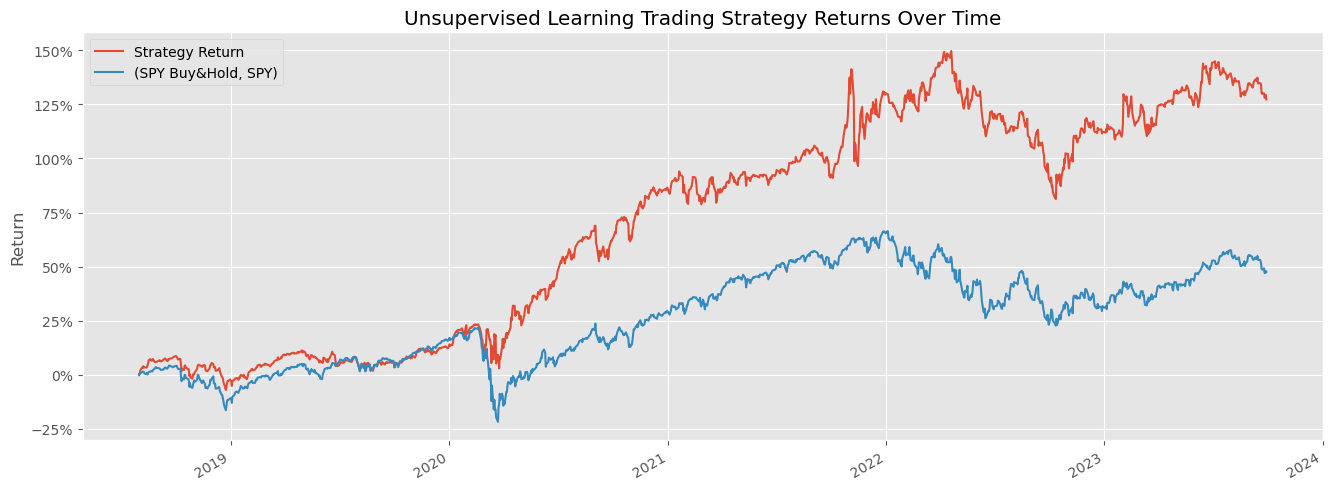

In [78]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolioCumulativeReturn = np.exp(np.log1p(portfolioDf).cumsum())-1

portfolioCumulativeReturn[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

## Final Remarks

#### `The orange line shows significant outperformance compared to the blue line.  Meaning that my strategy return method generated much higher returns.`
#### `Although there are slightly more drastic drops and rises indicated more volatility in my unsupervised strategy returns`
#### However, there is an overall positive trend with big chunks of consistency without as much fluctuation.  This could be due to selecting cluster 1 as our main portfolio optimizing factor.  And as we explored before our graphs showed that cluster 2 was a little less spread out than cluster 1 and that cluster 1 had higher RSI values that clustered near 70 as compared with cluster 2.  Since cluster 2 did follow after cluster 1 in terms of RSI values.  It could potentially be experimented with as a portfolio optimization factor to reduce volatility.  Although the returns maybe slightly less than my trading strategy right now, it will still be greater than SPY Buy&Hold returns due to the nature of their clustering in our ggplots earlier in this notebook.